<a href="https://colab.research.google.com/github/KAREN154/PlantPathoDetect-/blob/main/Tomato_Classification_Inception_%26_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.applications import InceptionV3
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####Building A CNN Model to Classify Tomato Images
>Tomato plants can exhibit various diseases and deficiencies that affect crop yield and quality. Accurately categorizing tomato plant conditions through leaf images is essential for effective crop management and disease control. By leveraging CNNs, the classification process can be automated, significantly improving the efficiency and accuracy of disease detection and plant health monitoring strategies.
CNNs excel at image analysis and feature extraction, allowing them to capture intricate details and patterns from tomato leaf images in the dataset.

**The convolutional layers in CNNs are able to identify:**
- Leaf color variations
- Spot patterns and lesions
- Texture changes
- Leaf venation patterns
- Disease-specific markings
- Nutrient deficiency symptoms

>These features enable the network to learn and distinguish between different tomato plant conditions. The pooling layers nested throughout the architecture down-sample the produced feature maps, allowing models to generalize leaf characteristics across different:

- Lighting conditions
- Leaf orientations
- Growth stages
- Image angles
- Environmental factors

In [3]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

class InceptionV3Model:
    def __init__(self, input_shape=(224, 224, 3), num_classes=6):  # Changed default to 6
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def build_model(self):
        # Load the InceptionV3 model pre-trained on ImageNet
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=self.input_shape)

        # Freeze the base model layers
        for layer in base_model.layers:
            layer.trainable = False

        # Add custom layers on top of the base model
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(self.num_classes, activation='softmax')(x)  # Now uses self.num_classes

        # Create the model
        self.model = Model(inputs=base_model.input, outputs=predictions)

        # Compile the model
        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    def train_model(self, train_dir, val_dir, batch_size=32, epochs=10):
        if self.model is None:
            self.build_model()

        # Define image size and batch size
        IMAGE_SIZE = self.input_shape[:2]

        # Define data generators
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        validation_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=IMAGE_SIZE,
            batch_size=batch_size,
            class_mode='categorical'
        )
        validation_generator = validation_datagen.flow_from_directory(
            val_dir,
            target_size=IMAGE_SIZE,
            batch_size=batch_size,
            class_mode='categorical'
        )

        # Verify number of classes matches
        if train_generator.num_classes != self.num_classes:
            raise ValueError(f"Number of classes in the data ({train_generator.num_classes}) "
                           f"doesn't match the model's output ({self.num_classes})")

        # Define callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            patience=3,
            factor=0.2,
            min_lr=1e-6
        )

        # Train the model
        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=[early_stopping, reduce_lr]
        )

    def evaluate_model(self, test_dir, batch_size=32):
        if self.model is None:
            raise ValueError("Model has not been built yet. Call build_model() first.")

        # Define image size
        IMAGE_SIZE = self.input_shape[:2]

        # Define data generator
        test_datagen = ImageDataGenerator(rescale=1./255)

        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=IMAGE_SIZE,
            batch_size=batch_size,
            class_mode='categorical'
        )

        # Evaluate the model
        test_loss, test_accuracy = self.model.evaluate(test_generator)
        print(f'Test Accuracy: {test_accuracy:.2f}')
        return test_loss, test_accuracy

    def plot_training_history(self):
        if self.history is None:
            print("No training history found. Please train the model first.")
            return

        plt.figure(figsize=(12, 6))

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()

In [4]:
# Instantiate the model
inception_model = InceptionV3Model()

# Build the model
inception_model.build_model()

# Define directories
train_dir = '/content/drive/MyDrive/PlantPathoDetect-/data/Tomato/Train_augmented'
val_dir = '/content/drive/MyDrive/PlantPathoDetect-/data/Tomato/Val'
test_dir = '/content/drive/MyDrive/PlantPathoDetect-/data/Tomato/Test'

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
inception_model.train_model(train_dir, val_dir, batch_size=64, epochs=5)

Found 33315 images belonging to 6 classes.
Found 2495 images belonging to 6 classes.
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


521/521 ━━━━━━━━━━━━━━━━━━━━ 8583s 16s/step - accuracy: 0.4798 - loss: 1.3649 - val_accuracy: 0.7816 - val_loss: 0.6286 - learning_rate: 0.0010
Epoch 2/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 5371s 10s/step - accuracy: 0.6871 - loss: 0.8595 - val_accuracy: 0.7703 - val_loss: 0.6154 - learning_rate: 0.0010
Epoch 3/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 5346s 10s/step - accuracy: 0.7242 - loss: 0.7629 - val_accuracy: 0.8160 - val_loss: 0.5406 - learning_rate: 0.0010
Epoch 4/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 5417s 10s/step - accuracy: 0.7338 - loss: 0.7275 - val_accuracy: 0.8116 - val_loss: 0.5354 - learning_rate: 0.0010
Epoch 5/5
521/521 ━━━━━━━━━━━━━━━━━━━━ 5463s 10s/step - accuracy: 0.7542 - loss: 0.6770 - val_accuracy: 0.8240 - val_loss: 0.5262 - learning_rate: 0.0010


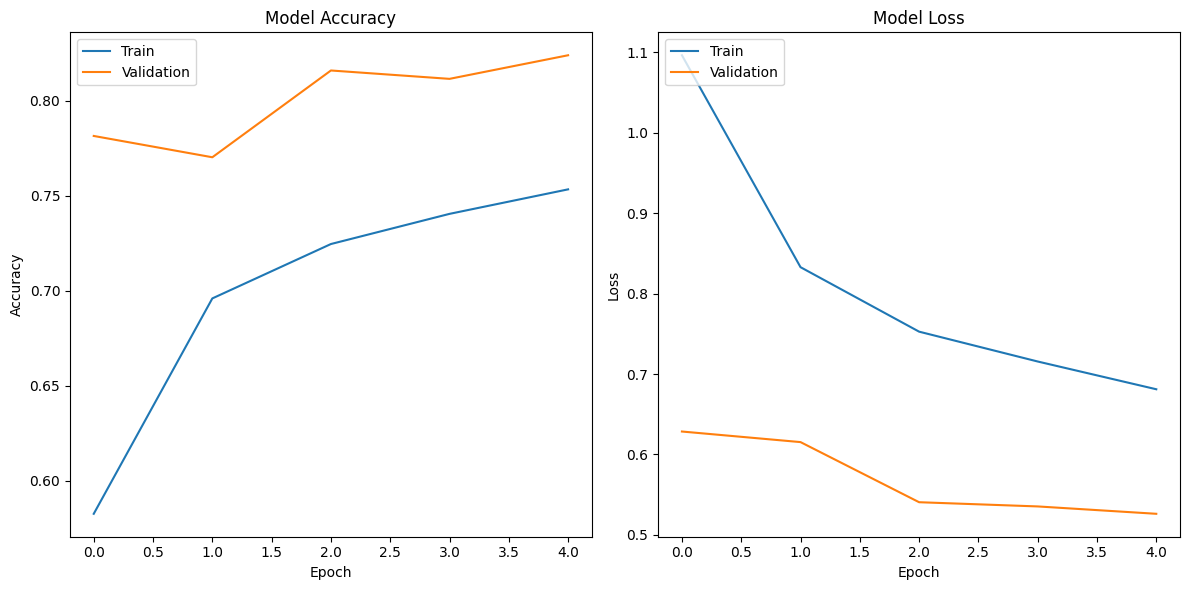

In [6]:
# Plot the training history
inception_model.plot_training_history()

In [9]:
class InceptionV3Model:
    def __init__(self, input_shape=(224, 224, 3), num_classes=6):  # Changed default to 6
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def save_model(self, filepath): # Added save_model method to the InceptionV3Model class
        """Saves the trained model to the specified filepath."""
        self.model.save(filepath) # Saves the model using the Keras save method

In [ ]:
# Instantiate the model
inception_model = InceptionV3Model()

In [11]:
# Save the trained model
inception_model.model.save('Tomato_inception_model.h5')


In [12]:
# Save the trained model using the recommended native Keras format
inception_model.model.save('Tomato_inception_model.keras')


In [13]:
import numpy as np
from sklearn.metrics import classification_report, f1_score

# Load the trained model
model = load_model('Tomato_inception_model.h5')

# Define image size and batch size
IMAGE_SIZE = (224, 224)

# Define data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Define test directory
test_dir = '/content/drive/MyDrive/PlantPathoDetect-/data/Tomato/Test'

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Make predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes
# Compute F1 score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'Weighted F1 Score: {f1:.2f}')

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)

Found 280 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 79s 9s/step
Weighted F1 Score: 0.86
                        precision    recall  f1-score   support

        Bacterial Spot       0.78      0.88      0.83        43
          Early Blight       0.75      0.85      0.80        48
               Healthy       0.92      1.00      0.96        49
           Late Blight       0.86      0.79      0.82        47
    Septoria Leaf Spot       0.85      0.66      0.74        44
Yellow Leaf Curl Virus       1.00      0.94      0.97        49

              accuracy                           0.86       280
             macro avg       0.86      0.85      0.85       280
          weighted avg       0.86      0.86      0.86       280



In [14]:
import numpy as np
from sklearn.metrics import classification_report, f1_score

# Load the trained model
model = load_model('Tomato_inception_model.keras')

# Define image size and batch size
IMAGE_SIZE = (224, 224)

# Define data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Define test directory
test_dir = '/content/drive/MyDrive/PlantPathoDetect-/data/Tomato/Test'

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Make predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes
# Compute F1 score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'Weighted F1 Score: {f1:.2f}')

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)

Found 280 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step
Weighted F1 Score: 0.86
                        precision    recall  f1-score   support

        Bacterial Spot       0.78      0.88      0.83        43
          Early Blight       0.75      0.85      0.80        48
               Healthy       0.92      1.00      0.96        49
           Late Blight       0.86      0.79      0.82        47
    Septoria Leaf Spot       0.85      0.66      0.74        44
Yellow Leaf Curl Virus       1.00      0.94      0.97        49

              accuracy                           0.86       280
             macro avg       0.86      0.85      0.85       280
          weighted avg       0.86      0.86      0.86       280

